# Root directory setup

Append the absolute path of the **root directory** to sys to access other subdirectories

In [25]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
print(nb_dir)
if nb_dir not in sys.path:
    sys.path.append(nb_dir) 

/Users/adamborgula/dev/bachelor_thesis/federated-learning


# Arguments

## Load arguments
- for every experiments, there are some arguments which are different from the default configuration
- replace the name of the experiment folder below to load the correct experiment args

In [26]:
experiment_category = "mag" # mag, synflow or fedspa
experiment = "test-experiment"

In [27]:
from utils.options import args_parser

# Read the arguments from the text file
args_file = nb_dir + '/save/results/' + experiment_category + '/' + experiment + '/args.txt'
print(args_file)
with open(args_file, 'r') as file:
    args = args_parser(file.read().split())


/Users/adamborgula/dev/bachelor_thesis/federated-learning/save/results/mag/test-experiment/args.txt


# Experiment 1

In [28]:
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import random

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, cifar_noniid
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar
from models.Fed import FedAvg, GlobalAvg
from models.test import test_img
import torch.nn as nn
import torchvision.models as models

from utils.prune_parameters import *
from numpy import random

import datetime
import random

- `get_successful_users` selects p users randomly

In [29]:
def get_successful_users(p, num_users):
    group1 = []
    group2 = []
    for i in range(0, num_users//2):
        if random.random() <= p:
            group1.append(i)
    for i in range(num_users//2, num_users):
        if random.random() <= p:
            group2.append(i)
    if len(group1) == 0:
        user = np.random.choice(range(num_users//2), 1, replace=False)
        group1.append(user[0])
    if len(group2) == 0:
        user = np.random.choice(range(num_users//2, num_users), 1, replace=False)
        group2.append(user[0])
    return group1 + group2


## Similarity based compensation
- `similarity_score` computes the similarty score between clients **u** and **v**
- `similarity_based_compensation` computes the similarity between all pairs of clients and returns the **similarity_matrix**

In [30]:
def similarity_score(u: int,v: int, w_locals, args) -> float:
    """
    Calculate the similarity score between two clients based on the Euclidean distance.

    Args:
        u (int): Index of the first client.
        v (int): Index of the second client.
        w_locals: The weights of each client

    Returns:
        float: The similarity score between the two clients based on the Euclidean distance.
    """
    # print('locals: ', len(w_locals), type(w_locals), w_locals[:2])
    w_u, w_v = w_locals[u], w_locals[v] 
    diference_vector = torch.tensor([]).to(args.device)
    for k in w_u.keys():
        # print('size k', k, w_u[k].size())
        diference_vector = torch.cat((diference_vector, torch.flatten(w_u[k]) - torch.flatten(w_v[k])), dim=0)
    distance = torch.norm(diference_vector)
    # print(u, v, 'distance', distance)
    # print('w_v', u, v, type(w_v), w_v.keys())
    # print('w_v layer 0',  type(w_v['layers.0.weight']), w_v['layers.0.weight'] )
    return -distance

def similarity_based_compensation(w_locals, users_received, args, sm):
    similarity_matrix = [i for i in range(len(w_locals))]
    for u in range(args.num_users):
        if u in users_received:
            continue

        # find the most similar received / updated user
        most_similar = users_received[0]
        for neighbor in users_received:
            # print('u, v, most_similar', u, neighbor, most_similar, similarity_score(u, neighbor, w_locals), similarity_score(u, most_similar, w_locals))
            similarity = similarity_score(u, neighbor, w_locals, args)
            sm[u][neighbor] = similarity.item() * -1
            sm[neighbor][u] = similarity.item() * -1
            if similarity > sm[u][most_similar]:
                most_similar = neighbor

        # update the similarity matrix
        similarity_matrix[u] = most_similar
    print(similarity_matrix)
    return similarity_matrix

- `experiment`

In [35]:
def run_experiment(experiment):
    # parse args
    args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
    print(args.device)

    iters = 5
    compression = 1
    alphas = [i/5 for i in range(0, iters)]
    # seeds = [0,99,345]
    seeds = [0]
    x_vals = [i for i in range(args.epochs_start, args.epochs_end, args.epochs_step)]
    y_vals = {'acc': [], 'loss': []}
    sm = [[0 for _ in range(args.num_users)] for _ in range(args.num_users)]

    for seed in seeds:
        # set random seed
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

        # load dataset and split users
        if args.dataset == 'mnist':
            trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
            dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
            dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
            # sample users
            if args.iid:
                dict_users = mnist_iid(dataset_train, args.num_users)
            else:
                dict_users = mnist_noniid(dataset_train, args.num_users)
        elif args.dataset == 'cifar':
            trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
            dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
            dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
            if args.iid:
                dict_users = cifar_iid(dataset_train, args.num_users)
            else:
                dict_users, train_set = cifar_noniid(dataset_train, args.num_users)
                print('dict_users', dict_users)
                print('train_set', train_set)
                print()
        else:
            exit('Error: unrecognized dataset')
        img_size = dataset_train[0][0].shape

        # build model
        if args.model == 'cnn' and args.dataset == 'cifar':
            net_glob = CNNCifar(args=args).to(args.device)
            #model = models.vgg16(weights = None)

            # Step 4: Modify last layer
            #num_classes = 10  # CIFAR-10 has 10 classes
            #model.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)
            #net_glob = model.to(args.device)
        elif args.model == 'cnn' and args.dataset == 'mnist':
            net_glob = CNNMnist(args=args).to(args.device)
        elif args.model == 'mlp':
            len_in = 1
            for x in img_size:
                len_in *= x
            net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
        elif args.model == 'resnet18' and args.dataset == 'cifar':
            model = models.resnet18()
            # Modify the last layer to have 10 output classes (CIFAR-10 has 10 classes)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, 10)
            net_glob = model.to(args.device)
        else:
            exit('Error: unrecognized model')
        print(net_glob)
        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()

        # training
        loss_train = []
        cv_loss, cv_acc = [], []
        val_loss_pre, counter = 0, 0
        net_best = None
        best_loss = None
        val_acc_list, net_list = [], []
        masks = [randomMask(net_glob, args.device, args.compression) for _ in range(args.num_users)]
        print('mask', len(masks), len(masks[0]), type(masks[0]), masks[0][0].size()) # Shape = 100 x 6 x 400 x 3072
        w_locals = [copy.deepcopy(w_glob) for i in range(args.num_users)]

        for iter in range(args.epochs_end):
            print("iteration",iter)
            loss_locals = []
            idxs_users = get_successful_users(args.p, args.num_users) 
            print('RANDOM USER INDICES', idxs_users)
            for idx in idxs_users:
                local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                w, loss, mask = local.train(net=copy.deepcopy(net_glob).to(args.device), mask=masks[idx], train_iter=iter)
                # print(w.keys())
                masks[idx] = mask
                w_locals[idx] = copy.deepcopy(w)
                loss_locals.append(copy.deepcopy(loss))
            # update global weights
            # similarity logic
            if args.compensation:
                similarity_matrix = similarity_based_compensation(w_locals, users_received=idxs_users, args=args, sm = sm)
                w_glob = GlobalAvg(w_locals, similarity_matrix)
            else:
                w_glob = GlobalAvg(w_locals, idxs_users)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
            loss_avg = sum(loss_locals) / len(loss_locals)
            print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
            loss_train.append(loss_avg)
            if (iter - args.epochs_start) % args.epochs_step == 0 and iter >= args.epochs_start:
                net_glob.eval()
                acc_test, loss_test = test_img(net_glob, dataset_train, args, train_set)
                print("Testing accuracy: {:.2f}".format(acc_test))
                print("Testing loss: {:.2f}".format(loss_test))

                y_vals['acc'].append(acc_test.item())
                y_vals['loss'].append(loss_test)
                #y_vals[args.pruner].append(0)

    print('test accuracy: ', y_vals['acc'])
    print('test loss: ', y_vals['loss'])
    # Plot both charts on the same axis
    plt.figure()
    plt.plot(x_vals, y_vals['acc'])
    plt.xlabel('Communication Rounds')
    plt.ylabel('Top-1 Accuracy')
    plt.title('')

    now = datetime.datetime.now()
    date = now.strftime("%Y_%m_%d")
    time = now.strftime("%H_%M_%S")

    # Create the directory if it doesn't exist
    save_dir = f"../save/results/{experiment_category}/{experiment}/{date}"
    os.makedirs(save_dir, exist_ok=True)

    # Save the plot
    plt.savefig(f"{save_dir}/similarity_test_acc_{args.prune_epochs}_{args.compensation}_{args.dataset}_{args.model}_{args.iid}_{args.p}_{args.num_users}_{args.epochs_start}_{args.epochs_end}_{time}.png")
    # plt.savefig('../save/synflow_test_{}_{}_{}_{}_{}_{}_{}.png'.format(args.prune_epochs, args.dataset, args.model, args.iid, args.frac, args.num_users, args.epochs))
    plt.figure()
    plt.plot(x_vals, y_vals['loss'])
    plt.xlabel('Communication Rounds')
    plt.ylabel('Loss')
    plt.title('')
    plt.savefig(f"{save_dir}/similarity_test_loss_{args.pruner}_{args.prune_epochs}_{args.compensation}_{args.dataset}_{args.model}_{args.iid}_{args.p}_{args.num_users}_{args.epochs_start}_{args.epochs_end}_{time}.png")
    np.savez(f"{save_dir}/similarity_test_loss_{args.pruner}_{args.prune_epochs}_{args.compensation}_{args.dataset}_{args.model}_{args.iid}_{args.p}_{args.num_users}_{args.epochs_start}_{args.epochs_end}_{time}", y = np.array(y_vals['loss']), x = np.array(x_vals))
    np.savez(f"{save_dir}/similarity_test_acc_{args.pruner}_{args.prune_epochs}_{args.compensation}_{args.dataset}_{args.model}_{args.iid}_{args.p}_{args.num_users}_{args.epochs_start}_{args.epochs_end}_{time}", y = np.array(y_vals['acc']), x = np.array(x_vals))
    plt.imshow(np.array(sm), cmap='viridis')  # cmap specifies the colormap (color scheme)
    plt.colorbar() 
    plt.savefig(f"{save_dir}/sm_{args.pruner}_{args.prune_epochs}_{args.compensation}_{args.dataset}_{args.model}_{args.iid}_{args.p}_{args.num_users}_{args.epochs_start}_{args.epochs_end}_{time}.png")

## Run The Experiment

cpu
Files already downloaded and verified
Files already downloaded and verified
[2 8 4 9 1]
dict_users {0: {21505, 24578, 48647, 11786, 46090, 11787, 35854, 4625, 12308, 9749, 33302, 14870, 44056, 10272, 18464, 24097, 11813, 3628, 19500, 45, 22064, 30771, 16947, 5683, 24631, 1082, 41018, 58, 15930, 12350, 19520, 579, 9803, 19020, 22095, 42066, 43602, 13910, 21590, 23129, 46171, 2654, 13406, 35936, 20580, 40550, 19558, 16486, 43623, 25201, 10866, 27762, 35956, 9333, 41077, 15477, 37494, 632, 25209, 39549, 8830, 9857, 4225, 2693, 26248, 24201, 34442, 19593, 12940, 21643, 40081, 6292, 17558, 40087, 5274, 23709, 28317, 36509, 18592, 36510, 46752, 34983, 38056, 6314, 9387, 4780, 47277, 29873, 18609, 2227, 7861, 5820, 11965, 43714, 18115, 1732, 5829, 34503, 13000, 44231, 23243, 16078, 24271, 4815, 17617, 4306, 19667, 35539, 26837, 44240, 32472, 31962, 32478, 13535, 12513, 28387, 48871, 10474, 27370, 28910, 9459, 9975, 27896, 20220, 28418, 13571, 16132, 17666, 37639, 25863, 41224, 3847, 49415

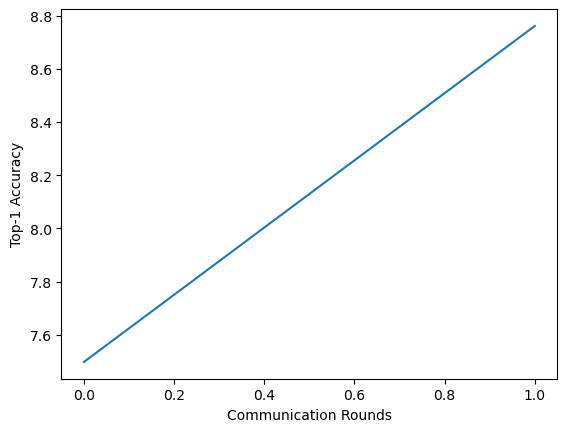

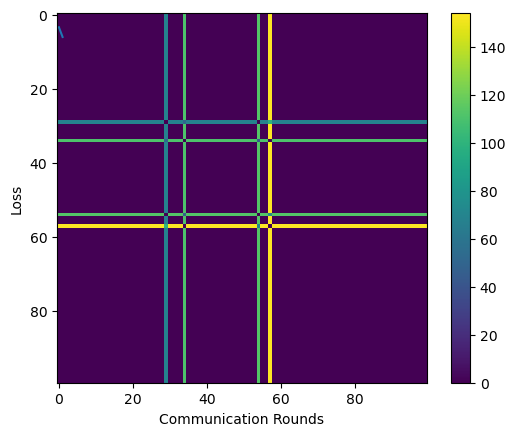

In [36]:
run_experiment(experiment)

In [ ]:
def run_experiment():
    x_vals, y_vals = [],[]

    args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

    alphas = [i/5 for i in range(10, 10+args.iters)]
    seeds = [0]
    x_vals = [10**alpha for alpha in alphas]
    y_vals = {'mag': [], 'synflow': []}

    for c in x_vals:
        for seed in seeds:
            np.random.seed(args.seed)
            torch.manual_seed(args.seed)
            torch.cuda.manual_seed(args.seed)
            torch.backends.cudnn.deterministic = True
            for pruner in ('synflow', 'mag'):
                args.pruner = pruner
                args.compression = c

                # load dataset and split users
                if args.dataset == 'mnist':
                    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
                    dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
                    dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
                    # sample users
                    if args.iid:
                        dict_users = mnist_iid(dataset_train, args.num_users)
                    else:
                        dict_users = mnist_noniid(dataset_train, args.num_users)
                elif args.dataset == 'cifar':
                    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
                    dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
                    dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
                    if args.iid:
                        dict_users = cifar_iid(dataset_train, args.num_users)
                    else:
                        exit('Error: only consider IID setting in CIFAR10')
                else:
                    exit('Error: unrecognized dataset')
                img_size = dataset_train[0][0].shape

                # build model
                if args.model == 'cnn' and args.dataset == 'cifar':
                    net_glob = CNNCifar(args=args).to(args.device)
                    #model = models.vgg16(weights = None)

                    # Step 4: Modify last layer
                    #num_classes = 10  # CIFAR-10 has 10 classes
                    #model.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)
                    #net_glob = model.to(args.device)
                elif args.model == 'cnn' and args.dataset == 'mnist':
                    net_glob = CNNMnist(args=args).to(args.device)
                elif args.model == 'mlp':
                    len_in = 1
                    for x in img_size:
                        len_in *= x
                    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
                else:
                    exit('Error: unrecognized model')
                print(net_glob)
                net_glob.train()

                # copy weights
                w_glob = net_glob.state_dict()

                # training
                loss_train = []
                cv_loss, cv_acc = [], []
                val_loss_pre, counter = 0, 0
                net_best = None
                best_loss = None
                val_acc_list, net_list = [], []

                if args.all_clients: 
                    print("Aggregation over all clients")
                    w_locals = [w_glob for i in range(args.num_users)]
                for iter in range(args.epochs):
                    loss_locals = []
                    if not args.all_clients:
                        w_locals = []
                    m = max(int(args.frac * args.num_users), 1)
                    idxs_users = [0]
                    for idx in idxs_users:
                        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
                        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
                        if args.all_clients:
                            w_locals[idx] = copy.deepcopy(w)
                        else:
                            w_locals.append(copy.deepcopy(w))
                        loss_locals.append(copy.deepcopy(loss))
                    # update global weights
                    w_glob = FedAvg(w_locals)

                    # copy weight to net_glob
                    net_glob.load_state_dict(w_glob)

                    # print loss
                    loss_avg = sum(loss_locals) / len(loss_locals)
                    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
                    loss_train.append(loss_avg)

                # plot loss curve
                # plt.figure()
                # plt.plot(range(len(loss_train)), loss_train)
                # plt.ylabel('train_loss')
                #   plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

                # testing
                net_glob.eval()
                acc_train, loss_train = test_img(net_glob, dataset_train, args)
                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                print("Training accuracy: {:.2f}".format(acc_train))
                print("Testing accuracy: {:.2f}".format(acc_test))

                y_vals[args.pruner].append(acc_test)
                #y_vals[args.pruner].append(0)

    print('synflow test accuracy: ', y_vals['synflow'])
    print('mag test accuracy: ', y_vals['mag'])
    # Plot both charts on the same axis
    plt.figure()
    plt.xscale('log')
    plt.plot(x_vals, y_vals['synflow'], label='Synflow', linestyle='-', marker='o', color='r')
    plt.plot(x_vals, y_vals['mag'], label='Mag', linestyle='-', marker='o', color='b')

    # Add labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Synflow vs Mag')

    # Add legend
    plt.legend()

   # Show plot
    if args.show:
        plt.show()

    # Save plot
    if args.save:
        plt.savefig('../save/synflow_test_{}_{}_{}.png'.format(args.prune_epochs, args.dataset, args.model))